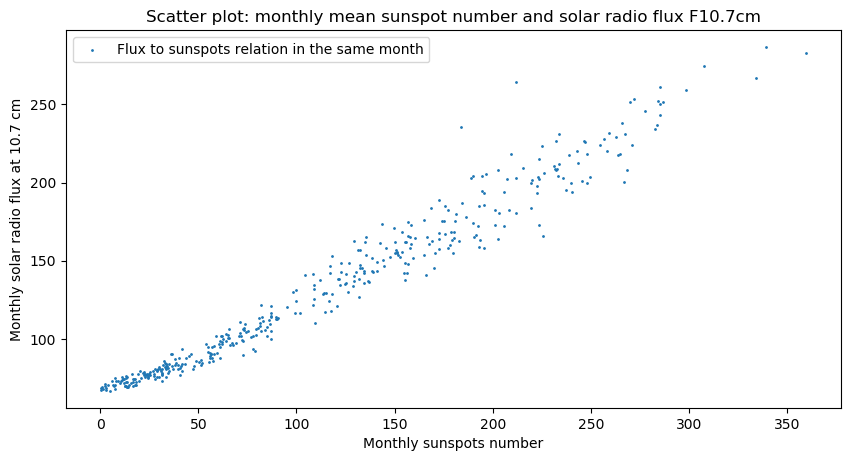

In [2]:
#Relationship between solar radio flux F10.7 and sunspot number
#Team 2:Ekaterina Karmanova, Timur Chikichev, Yaroslav Okunev, Nikita Mikhailovskiy
#Skoltech, 01.10.2019

#Library import
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')

#Data parsing from file
data = np.loadtxt('data_group2.txt',dtype={'names': ('year', 'month', 'flux', 'sunspots'),
                     'formats': ('i4', 'i4', 'f4','f4')})
years = np.array(data['year'])
monthes = np.array(data['month'])
flux = data['flux']
spots = data['sunspots']

#Scatter plot creation - Flux = f(Sunspots)
plt.scatter(spots, flux, 1, label = 'Flux to sunspots relation in the same month')
plt.title('Scatter plot: monthly mean sunspot number and solar radio flux F10.7cm')
plt.ylabel('Monthly solar radio flux at 10.7 cm')
plt.xlabel('Monthly sunspots number')
plt.legend()
plt.show()

(1 fig) By researching scatter plot we can assume the linear distribution of relationship between solar flux and sunspots monthly numbers. The main amount of points located within 100 records per month have a minimal diviation. 

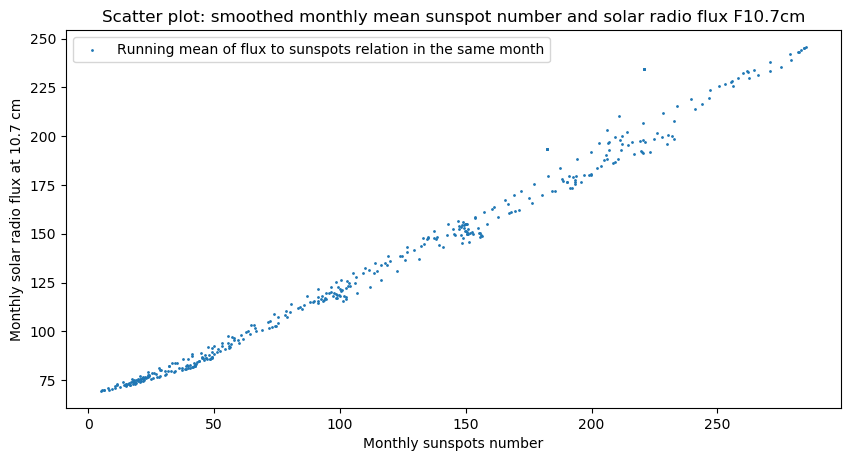

In [3]:
#Defining smooth function
def smooth_13(array):
    length = array.size
    smooth_arr = np.empty([length])
    
    #Pre-calculation: mean of the first six entries in dataset
    mean_first = 0
    for i in range (6):
        mean_first += array[i]
    mean_first /= 6 

    #Pre-calculation: mean of the last six entries in dataset
    mean_last = 0
    for i in range (6):
        mean_last += array[length - i - 1]
    mean_last /= 6 

    #Calculation for smoothing data in array including 13 monthes
    for i in range (0,length):
        if i < 6:
            smooth_arr[i] = mean_first
        elif i > (length - 7):
            smooth_arr[i] = mean_last
        else:
            #last values (less weighted)
            smooth_arr[i] = 1/24*array[i-6]
            smooth_arr[i] += 1/24*array[i+6]
            #middle values, counting the sum
            sum_it = 0
            for n in range (11):
                it = n - 5
                sum_it += 1/12*(array[i-it])
            smooth_arr[i] += sum_it
    return smooth_arr

#Calculation to subtract noise for flux and sunspots dataset
s_flux = smooth_13(flux)
s_spots = smooth_13(spots)

#Scatter plot - Flux = f(Sunspots) without noise
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(s_spots, s_flux, 1, label='Running mean of flux to sunspots relation in the same month')
plt.title('Scatter plot: smoothed monthly mean sunspot number and solar radio flux F10.7cm')
plt.ylabel('Monthly solar radio flux at 10.7 cm')
plt.xlabel('Monthly sunspots number')
plt.legend()
plt.show()      

After providing smoothing with running mean deviation was minimized. There is another curve tilt angle at the minimal count of sunspots and flux in compare with larger one. Therefore, this is not definetly linear relation. Also this data has some errors, that not corresponding with another points (misses).

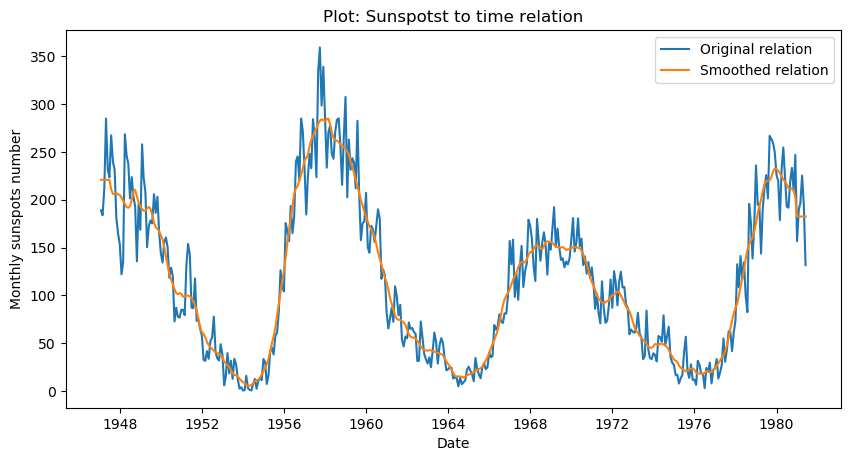

In [4]:
#Parsing years and monthes to get proper timestamp
from datetime import date
dates = [None]*years.size
for i in range (0,years.size):
    dates[i] = date(years[i], monthes[i],int(1))
    
#Plot - Sunspots = f(Time), original and smoothed
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.plot(dates, spots, label='Original relation')
plt.plot(dates,  smooth_13(spots), label='Smoothed relation')
plt.title('Plot: Sunspotst to time relation')
plt.xlabel('Date')
plt.ylabel('Monthly sunspots number')
plt.legend()
plt.show()

    

На графике видно, что сглаженная кривая проходит по траектории исходной кривой. По графику можно определить степень фильтрации случайного шума. Максимальная разница между шумом и отфильтрованным сигналом равна примерно 70 записям. 

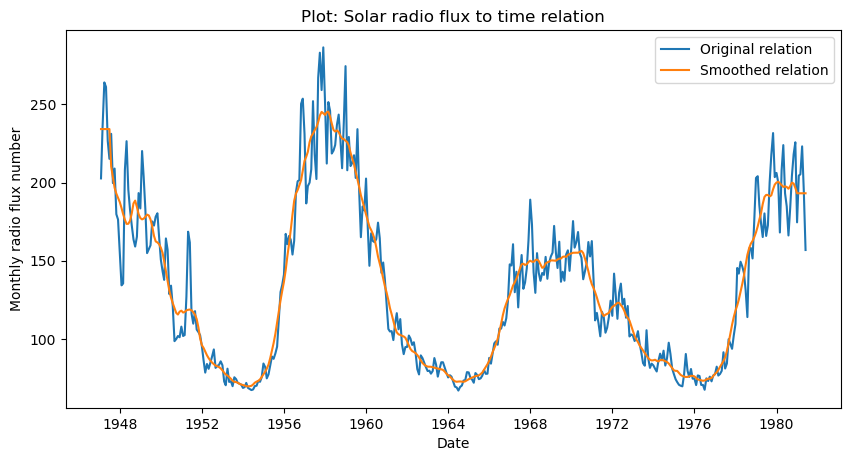

In [5]:
#Plot - Flux = f(Time), original and smoothed
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.plot(dates, flux, label='Original relation')
plt.plot(dates,  smooth_13(flux), label='Smoothed relation')
plt.title('Plot: Solar radio flux to time relation')
plt.xlabel('Date')
plt.ylabel('Monthly radio flux number')
plt.legend()
plt.show()

In [6]:
#Defining – Vector of dependent variables, regressand
F = flux.reshape(len(s_flux),1)

#Defining – Matrix of independent variables, regressors 
R = np.zeros((len(s_spots),4)).reshape(len(s_spots),4)
for i in range (0,len(s_spots)):
    R[i][0] = 1;
    R[i][1] = s_spots[i];
    R[i][2] = s_spots[i]**2;
    R[i][3] = s_spots[i]**3;

#Calculating the vector of coefficients by LSM
#Find transpose of regressors matrix
tr = R.transpose()
#Multiplicating of transposed regressors with original one
first = np.dot(tr,R)
#Inverse the result of multiplicating
inv = np.linalg.inv(first)
#Multiplicating of inversed result with transposed regressor
second = np.dot(inv,tr)
#Calculating vector of coefficients by multiplying previous result with regressand 
betta = np.dot(second, F)

print(betta)


[[ 6.36819323e+01]
 [ 4.69802297e-01]
 [ 1.19386416e-03]
 [-2.03526587e-06]]


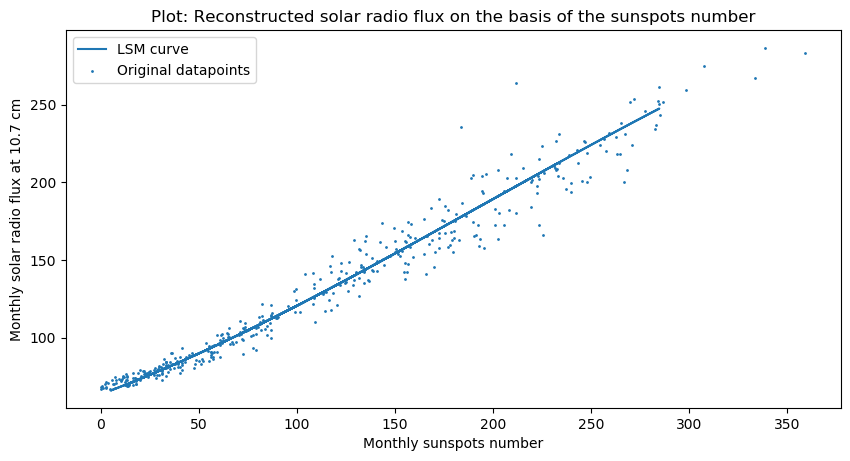

In [7]:
#Reconstruction of flux by using LSM calculated coefficients
flux_reconstructed = np.zeros(len(s_spots))
for i in range (0,len(s_spots)):
    flux_reconstructed[i] = betta[0]+betta[1]*s_spots[i]+betta[2]*s_spots[i]**2+betta[3]*s_spots[i]**3

#Plot - Reconstructed Flux = f(Sunspots)
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.plot(s_spots, flux_reconstructed, label='LSM curve')
plt.scatter(spots, flux, 1, label='Original datapoints')
plt.title('Plot: Reconstructed solar radio flux on the basis of the sunspots number')
plt.ylabel('Monthly solar radio flux at 10.7 cm')
plt.xlabel('Monthly sunspots number')
plt.legend()
plt.show()  

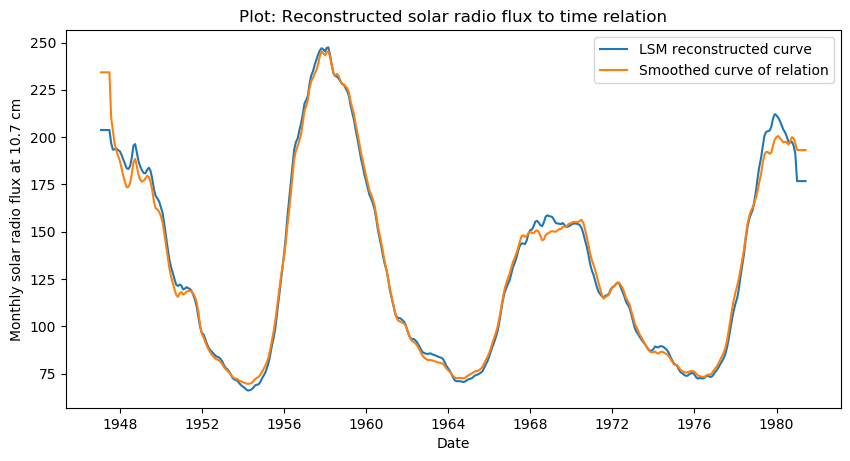

In [8]:
#Plot - Reconstructed Flux = f(Time)
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.plot(dates, flux_reconstructed, label='LSM reconstructed curve')
plt.plot(dates, s_flux, label='Smoothed curve of relation')
plt.title('Plot: Reconstructed solar radio flux to time relation')
plt.ylabel('Monthly solar radio flux at 10.7 cm')
plt.xlabel('Date')
plt.legend()
plt.show()  

In [9]:
#Determine the variance of estimation error of solar radio flux at 10.7
sum = 0
for i in range (0,len(s_flux)):
    sum += (s_flux[i] - (betta[0]+betta[1]*s_spots[i]+betta[2]*s_spots[i]**2+betta[3]*s_spots[i]**3))**2
delta2 = 1*(sum)/(len(s_flux)-1)

print(delta2)

[33.09042857]


Восстановленая кривая схожа с исходной (сглаженной). Присутствуют некоторые неточности при экстремумах (макс. значениях) восстановленной кривой. Также на границах наблюдаются ошибки. Сдвига кривых по времени не наблюдается.

Найденная погрешность данных по методу наименьших квадратов составляет 33. 

В ходе проделанной работы я начал ориентироваться в языке Python, научился строить графики и проводить вычисения. Вспомнил один из основных методов анализа экспериментальных данных - МНК. Ознакомился с новым методом - бегущая средняя, позволяющий сглаживать шумные данные. 

During laboratory work, I learned how to build plots and perform calculations in the Python language. I recalled one of the main methods for analyzing experimental data - least square method. I got acquainted with a new method - running mean, which allows to smoothing noisy data.
